In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [ ]:
def convert_video_to_images(img_folder, filename='assignment2_video.avi'):
  """
  Converts the video file (assignment2_video.avi) to JPEG images.
  Once the video has been converted to images, then this function doesn't
  need to be run again.
  Arguments
  ---------
  filename : (string) file name (absolute or relative path) of video file.
  img_folder : (string) folder where the video frames will be
  stored as JPEG images.
  """
  # Make the img_folder if it doesn't exist.'
  try:
    if not os.path.exists(img_folder):
      os.makedirs(img_folder)
  except OSError:
    print('Error')
  # Make sure that the abscense/prescence of path
  # separator doesn't throw an error.
  img_folder = f'{img_folder.rstrip(os.path.sep)}{os.path.sep}'
  # Instantiate the video object.
  video = cv2.VideoCapture(filename)
  # Check if the video is opened successfully
  if not video.isOpened():
    print("Error opening video file")
  i = 0
  while video.isOpened():
    ret, frame = video.read()
    if ret:
      im_fname = f'{img_folder}frame{i:0>4}.jpg'
      print('Captured...', im_fname)
      cv2.imwrite(im_fname, frame)
      i += 1
    else:
      break
  video.release()
  cv2.destroyAllWindows()

  if i:
    print(f'Video converted\n{i} images written to {img_folder}')

In [ ]:
path = '/content/assignment2_video.avi'
convert_video_to_images('/content',path)

Captured... /content/frame0000.jpg
Captured... /content/frame0001.jpg
Captured... /content/frame0002.jpg
Captured... /content/frame0003.jpg
Captured... /content/frame0004.jpg
Captured... /content/frame0005.jpg
Captured... /content/frame0006.jpg
Captured... /content/frame0007.jpg
Captured... /content/frame0008.jpg
Captured... /content/frame0009.jpg
Captured... /content/frame0010.jpg
Captured... /content/frame0011.jpg
Captured... /content/frame0012.jpg
Captured... /content/frame0013.jpg
Captured... /content/frame0014.jpg
Captured... /content/frame0015.jpg
Captured... /content/frame0016.jpg
Captured... /content/frame0017.jpg
Captured... /content/frame0018.jpg
Captured... /content/frame0019.jpg
Captured... /content/frame0020.jpg
Captured... /content/frame0021.jpg
Captured... /content/frame0022.jpg
Captured... /content/frame0023.jpg
Captured... /content/frame0024.jpg
Captured... /content/frame0025.jpg
Captured... /content/frame0026.jpg
Captured... /content/frame0027.jpg
Captured... /content

In [ ]:
def load_images(img_dir, im_width=60, im_height=44):
  """
  Reads, resizes and normalizes the extracted image frames from a folder.
  The images are returned both as a Numpy array of flattened images (i.e. the images with the 3-d shape (im_
  Arguments
  ---------
  img_dir : (string) the directory where the images are stored.
  im_width : (int) The desired width of the image.
  The default value works well.
  im_height : (int) The desired height of the image.
  The default value works well.
  Returns
  X : (numpy.array) An array of the flattened images.
  images : (list) A list of the resized images.
  """
  images = []
  fnames = glob(f'{img_dir}{os.path.sep}frame*.jpg')
  fnames.sort()
  for fname in fnames:
    im = Image.open(fname)
    # resize the image to im_width and im_height.
    im_array = np.array(im.resize((im_width, im_height)))
    # Convert uint8 to decimal and normalize to 0 - 1.
    images.append(im_array.astype(np.float32) / 255.)
    # Close the PIL image once converted and stored.
    im.close()
  # Flatten the images to a single vector
  X = np.array(images).reshape(-1, np.prod(images[0].shape))
  return X, images

In [ ]:
X, images = load_images('/content',60,44)

In [ ]:
X.shape

(1050, 7920)

In [ ]:
image = np.array(images)

In [ ]:
image.shape

(1050, 44, 60, 3)

In [ ]:
# Network parameters
input_shape = image.shape[1:]
batch_size = 128
kernel_size = 3
latent_dim = 16
# Encoder/Decoder number of CNN layers and filters per layer (depth)
layer_filters = [32, 64]

# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 44, 60, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 22, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 15, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 10560)             0         
                                                                 
 latent_vector (Dense)       (None, 16)                168976    
                                                                 
Total params: 188,368
Trainable params: 188,368
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 10560)             179520    
                                                                 
 reshape (Reshape)           (None, 11, 15, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 22, 30, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 44, 60, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 44, 60, 1)        289 

In [ ]:
autoencoder.compile(loss='mse', optimizer='adam')

In [ ]:
# Train the autoencoder
autoencoder.fit(image,
                image,
                epochs=10,
                batch_size=batch_size)

Epoch 1/10
9/9 [==============================] - 6s 599ms/step - loss: 0.0773
Epoch 2/10
9/9 [==============================] - 5s 596ms/step - loss: 0.0292
Epoch 3/10
9/9 [==============================] - 5s 596ms/step - loss: 0.0142
Epoch 4/10
9/9 [==============================] - 5s 596ms/step - loss: 0.0085
Epoch 5/10
9/9 [==============================] - 5s 592ms/step - loss: 0.0064
Epoch 6/10
9/9 [==============================] - 5s 595ms/step - loss: 0.0059
Epoch 7/10
9/9 [==============================] - 5s 599ms/step - loss: 0.0056
Epoch 8/10
9/9 [==============================] - 5s 594ms/step - loss: 0.0055
Epoch 9/10
9/9 [==============================] - 6s 609ms/step - loss: 0.0055
Epoch 10/10
9/9 [==============================] - 5s 598ms/step - loss: 0.0055


In [ ]:
loss_list = []
for i in range(image.shape[0]):
  frame = image[i].reshape(-1, 44, 60, 3)
  loss = autoencoder.evaluate(frame, frame, verbose=0)
  loss_list.append(loss)

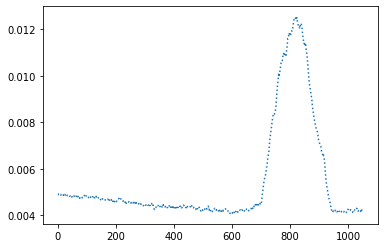

In [ ]:
plt.plot(loss_list, linestyle = 'dotted')
plt.show()

In [ ]:
def predict(frame):
  """
  Argument
  --------
  frame : Video frame with shape == (44, 60, 3) and dtype == float.
  Return
  anomaly : A boolean indicating whether the frame is an anomaly or not.
  ------
  """
  frame = frame.reshape(-1, 44, 60, 3)
  loss = autoencoder.evaluate(frame, frame, verbose=0)
  threshold = 0.006
  if loss >= threshold:
    anomaly = True
  else:
    anomaly = False
  return anomaly

In [ ]:
detect = []
image_number = []
for i in range(len(images)):
  image_n = 'frame' + "{:04n}".format(i)
  image_number.append(image_n)
  detect.append(predict(image[i]))
result = pd.DataFrame({'name':image_number,'anomaly':detect})

In [ ]:
result

,name,anomaly
0,frame0000,False
1,frame0001,False
2,frame0002,False
3,frame0003,False
4,frame0004,False
...,...,...
1045,frame1045,False
1046,frame1046,False
1047,frame1047,False
1048,frame1048,False


In [ ]:
# some examples
predict(image[0])

False

In [ ]:
predict(image[800])

True

In [ ]:
predict(image[710])

True